## <font color='red'>Distinguishing ants from bees</font>

This notebook builds a classifier that distinguishes between images of ants and bees. The classifier has three parts to it:
- The images are of varying sizes. So first, they are all normalized to a fixed size.
- Then they are run through a pre-trained computer vision neural net, ResNet50, that produces a 2048-dimensional representation
- Finally, a logistic regression classifier is built on top of this representation.

### <font color='red'>Various includes</font>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
# Torch stuff
import torch
import torch.nn as nn
# Torchvision stuff
from torchvision import datasets, models, transforms
# sklearn stuff
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### <font color='red'>Loading Dataset</font>

For both the train and test data, the images need to be normalized to the particular size, 224x224x3, that is required by the ResNet50 network that we will apply to them. This is achieved by a series of transforms.

- The (normalized) training set is in image_datasets['train']
- The (normalized) test set is in image_datasets['val']


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

#### <font color='red'>Look at the classes and data set sizes</font>

In [3]:
class_names = image_datasets['train'].classes
class_names

['ants', 'bees']

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes

{'train': 246, 'val': 153}

#### <font color='red'>Print a sample (transformed) image</font>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bees



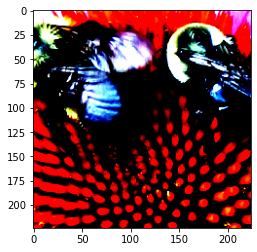

In [5]:
item = 200
[itemx,itemy] = image_datasets['train'].__getitem__(item)
print("Label: {}\n".format(class_names[itemy]))
plt.imshow(itemx.permute(1, 2, 0))
plt.show()

### <font color='red'>Load pre-trained ResNet50</font>

Torch has a bunch of pre-trained nets for computer vision. Let's try out one of them: ResNet50. 

In [6]:
resnet50 = models.resnet50(pretrained = True)
modules = list(resnet50.children())[:-1]
resnet50 = nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False

### <font color='red'>Extract ResNet features from dataset</font>

We'll use ResNet to produce a 2048-dimensional representation for each image.

The resulting training set will be in the Numpy arrays (X_train, y_train) and the test set will be in the Numpy arrays (X_test, y_test).


In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x])
              for x in ['train', 'val']}
for batch,data in enumerate(dataloaders['train']):
    if batch==0:
        X_train = torch.squeeze(resnet50(data[0])).numpy()
        y_train = data[1].numpy()
    else:
        X_train = np.vstack((X_train,torch.squeeze(resnet50(data[0])).numpy()))
        y_train = np.hstack((y_train,data[1].numpy()))


for batch,data in enumerate(dataloaders['val']):
    if batch==0:
        X_test = torch.squeeze(resnet50(data[0])).numpy()
        y_test = data[1].numpy()
    else:
        X_test = np.vstack((X_test,torch.squeeze(resnet50(data[0])).numpy()))
        y_test = np.hstack((y_test,data[1].numpy()))


In [8]:
np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test)

((246, 2048), (246,), (153, 2048), (153,))

### <font color='red'>Train logistic regression classifier on the ResNet features</font>

And then we'll evaluate its performance on the test set.

In [9]:
clf = LogisticRegression(solver='liblinear',random_state=0,max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0, solver='liblinear')

In [10]:
y_pred = clf.predict(X_test)
print("Accuracy: {}\n".format(accuracy_score(y_test,y_pred)))
print("Confusion matrix: \n {}".format(confusion_matrix(y_test,y_pred)))

Accuracy: 0.8300653594771242

Confusion matrix: 
 [[60 10]
 [16 67]]


# (a) Pick an image from the directory and show both the original version and the normalized version.

In [11]:
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_data = datasets.ImageFolder(os.path.join(data_dir, 'val'))

Original version:
Label: ants



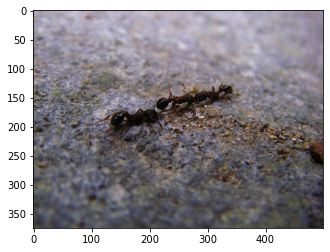

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Normalized version:
Label: ants



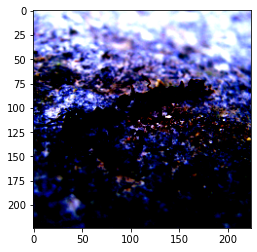



Original version:
Label: ants



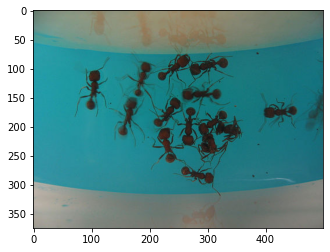

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Normalized version:
Label: ants



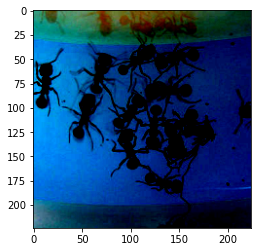



Original version:
Label: ants



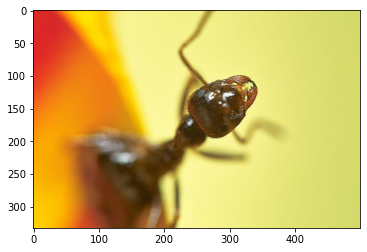

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Normalized version:
Label: ants



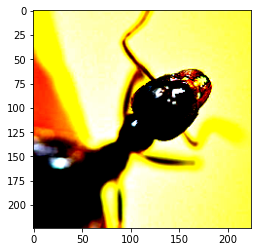



Original version:
Label: bees



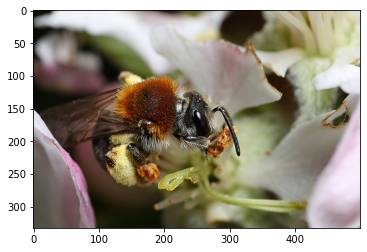

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Normalized version:
Label: bees



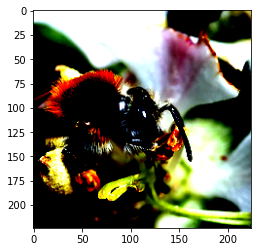



Original version:
Label: bees



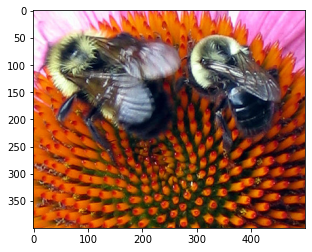

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Normalized version:
Label: bees



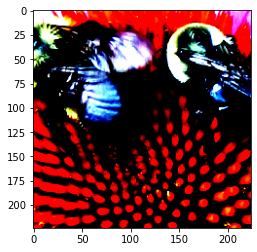



Original version:
Label: bees



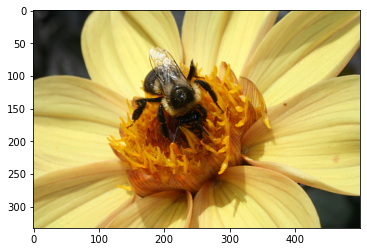

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Normalized version:
Label: bees



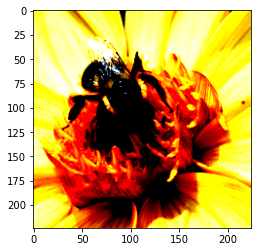

In [12]:
items = [10, 90, 100, 160, 200, 240]
for item in items:
    print('Original version:')
    [itemx,itemy] = train_data.__getitem__(item)
    print("Label: {}\n".format(class_names[itemy]))
    plt.imshow(itemx)
    plt.show()
    
    
    print('\nNormalized version:')
    [itemx,itemy] = image_datasets['train'].__getitem__(item)
    print("Label: {}\n".format(class_names[itemy]))
    plt.imshow(itemx.permute(1, 2, 0))
    plt.show()
    
    print('\n')

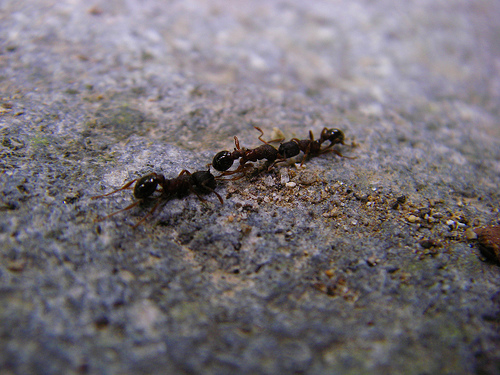

In [13]:
# Or we can show the original version like the following.
[itemx,itemy] = train_data.__getitem__(10)
itemx

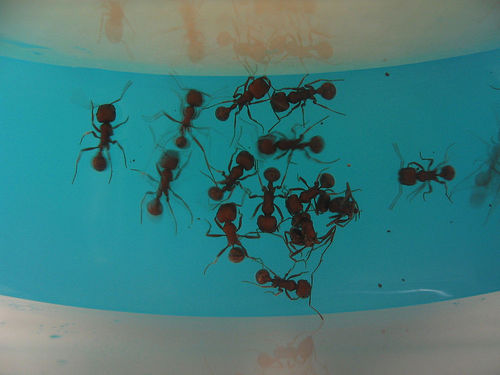

In [14]:
[itemx,itemy] = train_data.__getitem__(90)
itemx

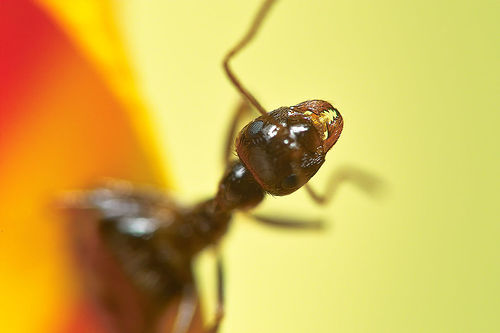

In [15]:
[itemx,itemy] = train_data.__getitem__(100)
itemx

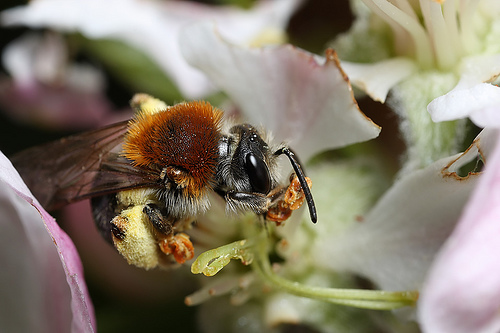

In [16]:
[itemx,itemy] = train_data.__getitem__(160)
itemx

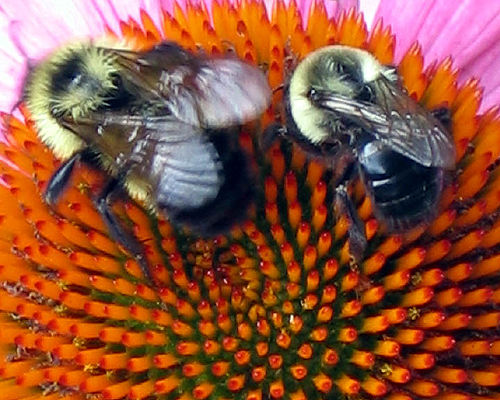

In [17]:
[itemx,itemy] = train_data.__getitem__(200)
itemx

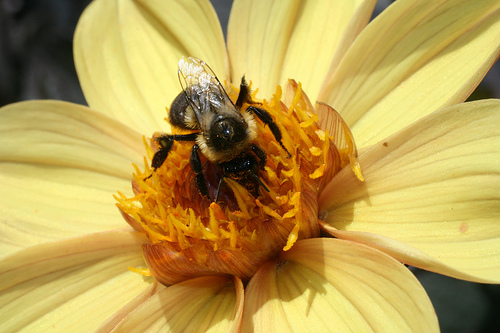

In [18]:
[itemx,itemy] = train_data.__getitem__(240)
itemx

# (b) Now, use this same 2048-d representation to construct a k-nearest neighbor classifier. Give the test accuracies obtained for k = 1, 3, 5.

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
for k in [1,3,5]:
    print('\nk =', k)
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    print("\nAccuracy: {}\n".format(accuracy_score(y_test,y_pred)))
    print("Confusion matrix: \n {}".format(confusion_matrix(y_test,y_pred)))


k = 1

Accuracy: 0.6535947712418301

Confusion matrix: 
 [[42 28]
 [25 58]]

k = 3

Accuracy: 0.7254901960784313

Confusion matrix: 
 [[52 18]
 [24 59]]

k = 5

Accuracy: 0.7254901960784313

Confusion matrix: 
 [[52 18]
 [24 59]]
